<h1 style="color: green;">  Smart Cart </h1>

### Modeling

#### INDEX

- [Data Preprocessing](#DP)
- [Vectorization - Bag of words](#5)
- [Apply on train set](#5)
- [Apply on train set](#6)
- [Plotting a visual with the most frequently occurred words](#7)
- [Conclusion](#8)

<a id='INDEX'></a>

In this notebook we will convert Product column into a numerical column using Vectorization - Bag of words using tokenizer PorterStemmer and stopwords on train and test data.

In [15]:
# Import required libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get rid of warning message
import warnings
warnings.filterwarnings('ignore')

import session_info
session_info.show()

Continue conducting EDA focusing on order items and department/isles of these products.

### Data Preprocessing

In [16]:
# Download the final train orders version of our dataframe - combined train dataset:
df = pd.read_csv('data/df_train.csv',index_col=0)
df

,product_id,add_to_cart_order,reordered,user_id,order_number,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
order_id,,,,,,,,,,,
1,49302,1,1,112108,4,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
816049,49302,7,1,47901,14,16.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1242203,49302,1,1,2993,15,7.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1383349,49302,11,1,41425,4,14.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1787378,49302,8,0,187205,5,30.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...
3420011,1528,12,0,177077,4,30.0,Sprinkles Decors,97,13,baking supplies decor,pantry
3420084,47935,20,0,9808,9,30.0,Classic Original Lip Balm SPF 12,73,11,facial care,personal care
3420084,9491,21,0,9808,9,30.0,Goats Milk & Chai Soap,25,11,soap,personal care


In [17]:
# Drop aisle_id and department_id columns:
df = df.drop(['aisle_id', 'department_id','aisle','department','product_id','user_id'], axis=1)
df

,add_to_cart_order,reordered,order_number,days_since_prior_order,product_name
order_id,,,,,
1,1,1,4,9.0,Bulgarian Yogurt
816049,7,1,14,16.0,Bulgarian Yogurt
1242203,1,1,15,7.0,Bulgarian Yogurt
1383349,11,1,4,14.0,Bulgarian Yogurt
1787378,8,0,5,30.0,Bulgarian Yogurt
...,...,...,...,...,...
3420011,12,0,4,30.0,Sprinkles Decors
3420084,20,0,9,30.0,Classic Original Lip Balm SPF 12
3420084,21,0,9,30.0,Goats Milk & Chai Soap


In [18]:
df['reordered'].value_counts(normalize=True)

reordered
1    0.598594
0    0.401406
Name: proportion, dtype: float64

Our base accuracy of reordered is 59,86%. The model is slightly imbalanced.

In [19]:
#First we assign X and y. Since our target column is 'reordered', we will drop it and make it our y.

# Store data in X and y
X = df.drop(columns='reordered') #input
y = df['reordered'] #output

We split our data into train and test sets so we can test our model on unseen data. Testing on unseen data is the last step in the modeling process to validate that our model can still perform well when it comes across data that it doesnt know:

In [20]:
# Split our data into train and test sets:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [21]:
# check shapes of train and test sets:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1107693, 4) (276924, 4) (1107693,) (276924,)


After splitting our data into train and test sets, we can move on to vectorizing our review columns. 
Using a Count Vectorizer, we will be able to turn our text data into a number of binary columns. 
The vectorizer will split the reviews by word and then create a binary column that identifies if the word is in the review or not.

## Vectorization - Bag of words 

### Apply on train set:
<a id='5'></a>

In [22]:
# We must import the requiered packages:
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dariiav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We will be using the function my_tokenizer that will clean the reviews before being put into the vectorizer. This function will go through a 3 step process:

1. Remove all punctuation
2. Split the string and remove stop words (common English words)
3. Stem each word in the string

In [23]:
# tokenizer function
stemmer = PorterStemmer()
ENGLISH_STOP_WORDS = stopwords.words('english')
def my_tokenizer(sentence):
    '''
    Takes a sentence:
    - Removes the punctuation
    - Separates and Removes Stop Words
    - Stems the remaining tokens
    Returns list of stemmed tokens
    '''
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark, '').lower()
    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word != '') and (not word.isdigit()):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)
    return listofstemmed_words

Now we have the cleaning function layed out, we can move on to vectorizing ¨product_name¨ column.
We have set min_df to 100. This will keep words that are seen more than 100 times.
There is also max_features set to 500. This will cap the number of words we extract to 500 for the Product Names.

In [24]:
# 1. Instantiate 
bagofwords = CountVectorizer(tokenizer=my_tokenizer, min_df=100, max_features=500) #vector consisting of the count of the words

# 2. Fit & Transform on train set
X_train_transformed = bagofwords.fit_transform(X_train['product_name']).toarray()
X_train_transformed

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Bag of words

### Apply on test set:
<a id='6'></a>

In [26]:
# Transform on test set
X_test_transformed = bagofwords.transform(X_test['product_name']).toarray()
X_test_transformed

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Since our column has been vectorized, lets check the size of it to make sure vectoriation process went correctly:

In [27]:
# size of arrays
print(X_train_transformed.shape, X_test_transformed.shape)

(1107693, 500) (276924, 500)


Arrays shapes correspond containing exact 500 words.

In [28]:
# Lets take a look at the words extracted
bagofwords.get_feature_names_out()

array(['aa', 'acai', 'ad', 'age', 'air', 'ale', 'alfresco', 'almond',
       'almondmilk', 'altern', 'american', 'appl', 'arugula', 'asparagu',
       'avocado', 'babi', 'bacon', 'bag', 'bagel', 'bake', 'banana',
       'bar', 'bartlett', 'basil', 'bath', 'bathroom', 'bean', 'beef',
       'beer', 'beet', 'bell', 'berri', 'beverag', 'biscuit', 'bite',
       'black', 'blackberri', 'blend', 'blue', 'blueberri', 'boneless',
       'bottom', 'bowl', 'bread', 'breakfast', 'breast', 'breez', 'brew',
       'broccoli', 'broth', 'brown', 'browni', 'brussel', 'bun', 'bunch',
       'bunni', 'burger', 'burrito', 'butter', 'buttermilk', 'butternut',
       'cabbag', 'cage', 'cake', 'calcium', 'california', 'calori',
       'candi', 'cane', 'caramel', 'carrot', 'cashew', 'cat', 'cauliflow',
       'celeri', 'cereal', 'cheddar', 'cheerio', 'chees', 'cherri',
       'chewi', 'chia', 'chicken', 'chile', 'chili', 'chip', 'chocol',
       'chop', 'chunk', 'chunki', 'cilantro', 'cinnamon', 'citru',
   

In [29]:
# Create dataframe from the vectorized arrays with column name my_product_basket assigned:

df_train_transformed = pd.DataFrame(X_train_transformed, columns=bagofwords.get_feature_names_out())

df_test_transformed = pd.DataFrame(X_test_transformed, columns=bagofwords.get_feature_names_out())

In [30]:
# Sanity check
df_train_transformed.sum()

aa           3865
acai         1624
ad           4105
age          3296
air          1379
            ...  
yoghurt      2692
yogurt      41686
yokid        2034
zero         2855
zucchini     4596
Length: 500, dtype: int64

In [31]:
# Sanity check head
df_test_transformed.head()

,aa,acai,ad,age,air,ale,alfresco,almond,almondmilk,altern,...,whole,wild,wipe,yam,yellow,yoghurt,yogurt,yokid,zero,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Both the test and train sets are correctly transformed, now we concatenate it with our original train and test data. It will include vectorized product names together with other features.

In [32]:
# Drop product_name column from test and train data sets

X_train = X_train.drop(columns=['product_name']).reset_index(drop=True)

X_test = X_test.drop(columns=['product_name']).reset_index(drop=True)
X_test

,add_to_cart_order,order_number,days_since_prior_order
0,1,5,30.0
1,4,28,6.0
2,13,14,17.0
3,4,8,30.0
4,7,5,27.0
...,...,...,...
276919,5,14,7.0
276920,6,26,8.0
276921,5,46,7.0
276922,3,6,15.0


In [33]:
# Create a combined final dfs ready for modeling:
# X Train data:
X_train = pd.concat([df_train_transformed.reset_index(drop=True), X_train], axis=1)
X_train

,aa,acai,ad,age,air,ale,alfresco,almond,almondmilk,altern,...,yam,yellow,yoghurt,yogurt,yokid,zero,zucchini,add_to_cart_order,order_number,days_since_prior_order
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,10,30.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,7,7.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,20,21,8.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,22,8,30.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,21,26,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,100,4.0
1107689,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,4,20.0
1107690,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,8,18.0
1107691,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12,8,30.0


In [34]:
# Concat df_test_transformed and X Test data:
X_test = pd.concat([df_test_transformed.reset_index(drop=True), X_test], axis=1)
X_test

,aa,acai,ad,age,air,ale,alfresco,almond,almondmilk,altern,...,yam,yellow,yoghurt,yogurt,yokid,zero,zucchini,add_to_cart_order,order_number,days_since_prior_order
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,5,30.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,28,6.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,13,14,17.0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,8,30.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,5,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,14,7.0
276920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,26,8.0
276921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,46,7.0
276922,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,3,6,15.0


All of our data is now numerical and ready for modeling.

In [2]:
#Save df to continue working for future notebooks:
#X_test.to_csv("data/X_test_final.csv", index=False, header=True)

In [52]:
#X_train.to_csv("data/X_train_final.csv", index=False, header=True)

In [37]:
#y_test.to_csv("data/y_test_final.csv", index=False, header=True)

In [38]:
#y_train.to_csv("data/y_train_final.csv", index=False, header=True)

### Plotting a visual with the most frequently occurred words
<a id='7'></a>

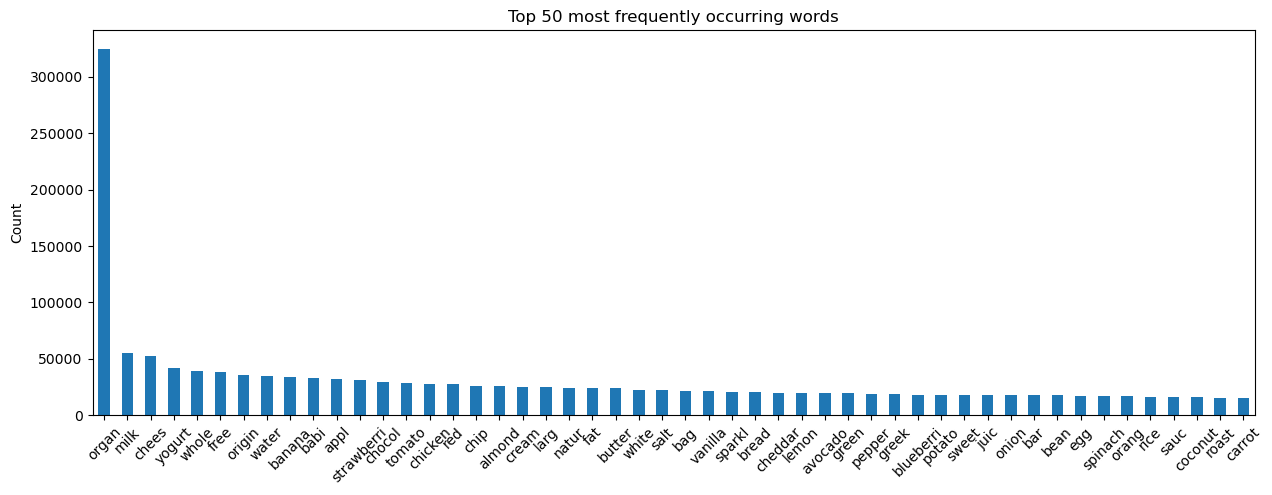

In [39]:
word_counts = pd.DataFrame(
    {"counts": df_train_transformed.sum(axis=0)},
    index=bagofwords.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(50).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 50 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45);

Organic is by far the most common word by a big difference, followed by milk, cheese, yogurt and 'whole' - are the most common words encountered in the product names.

The results are aligned with the plots during the EDA where we analyzed the most frequent items from customers orders.

---

### Conclusion
<a id='8'></a>

Now, as we have all columns in numerical format, it is the final version of the df ready for modeling.

### [BACK TO INDEX](#INDEX)